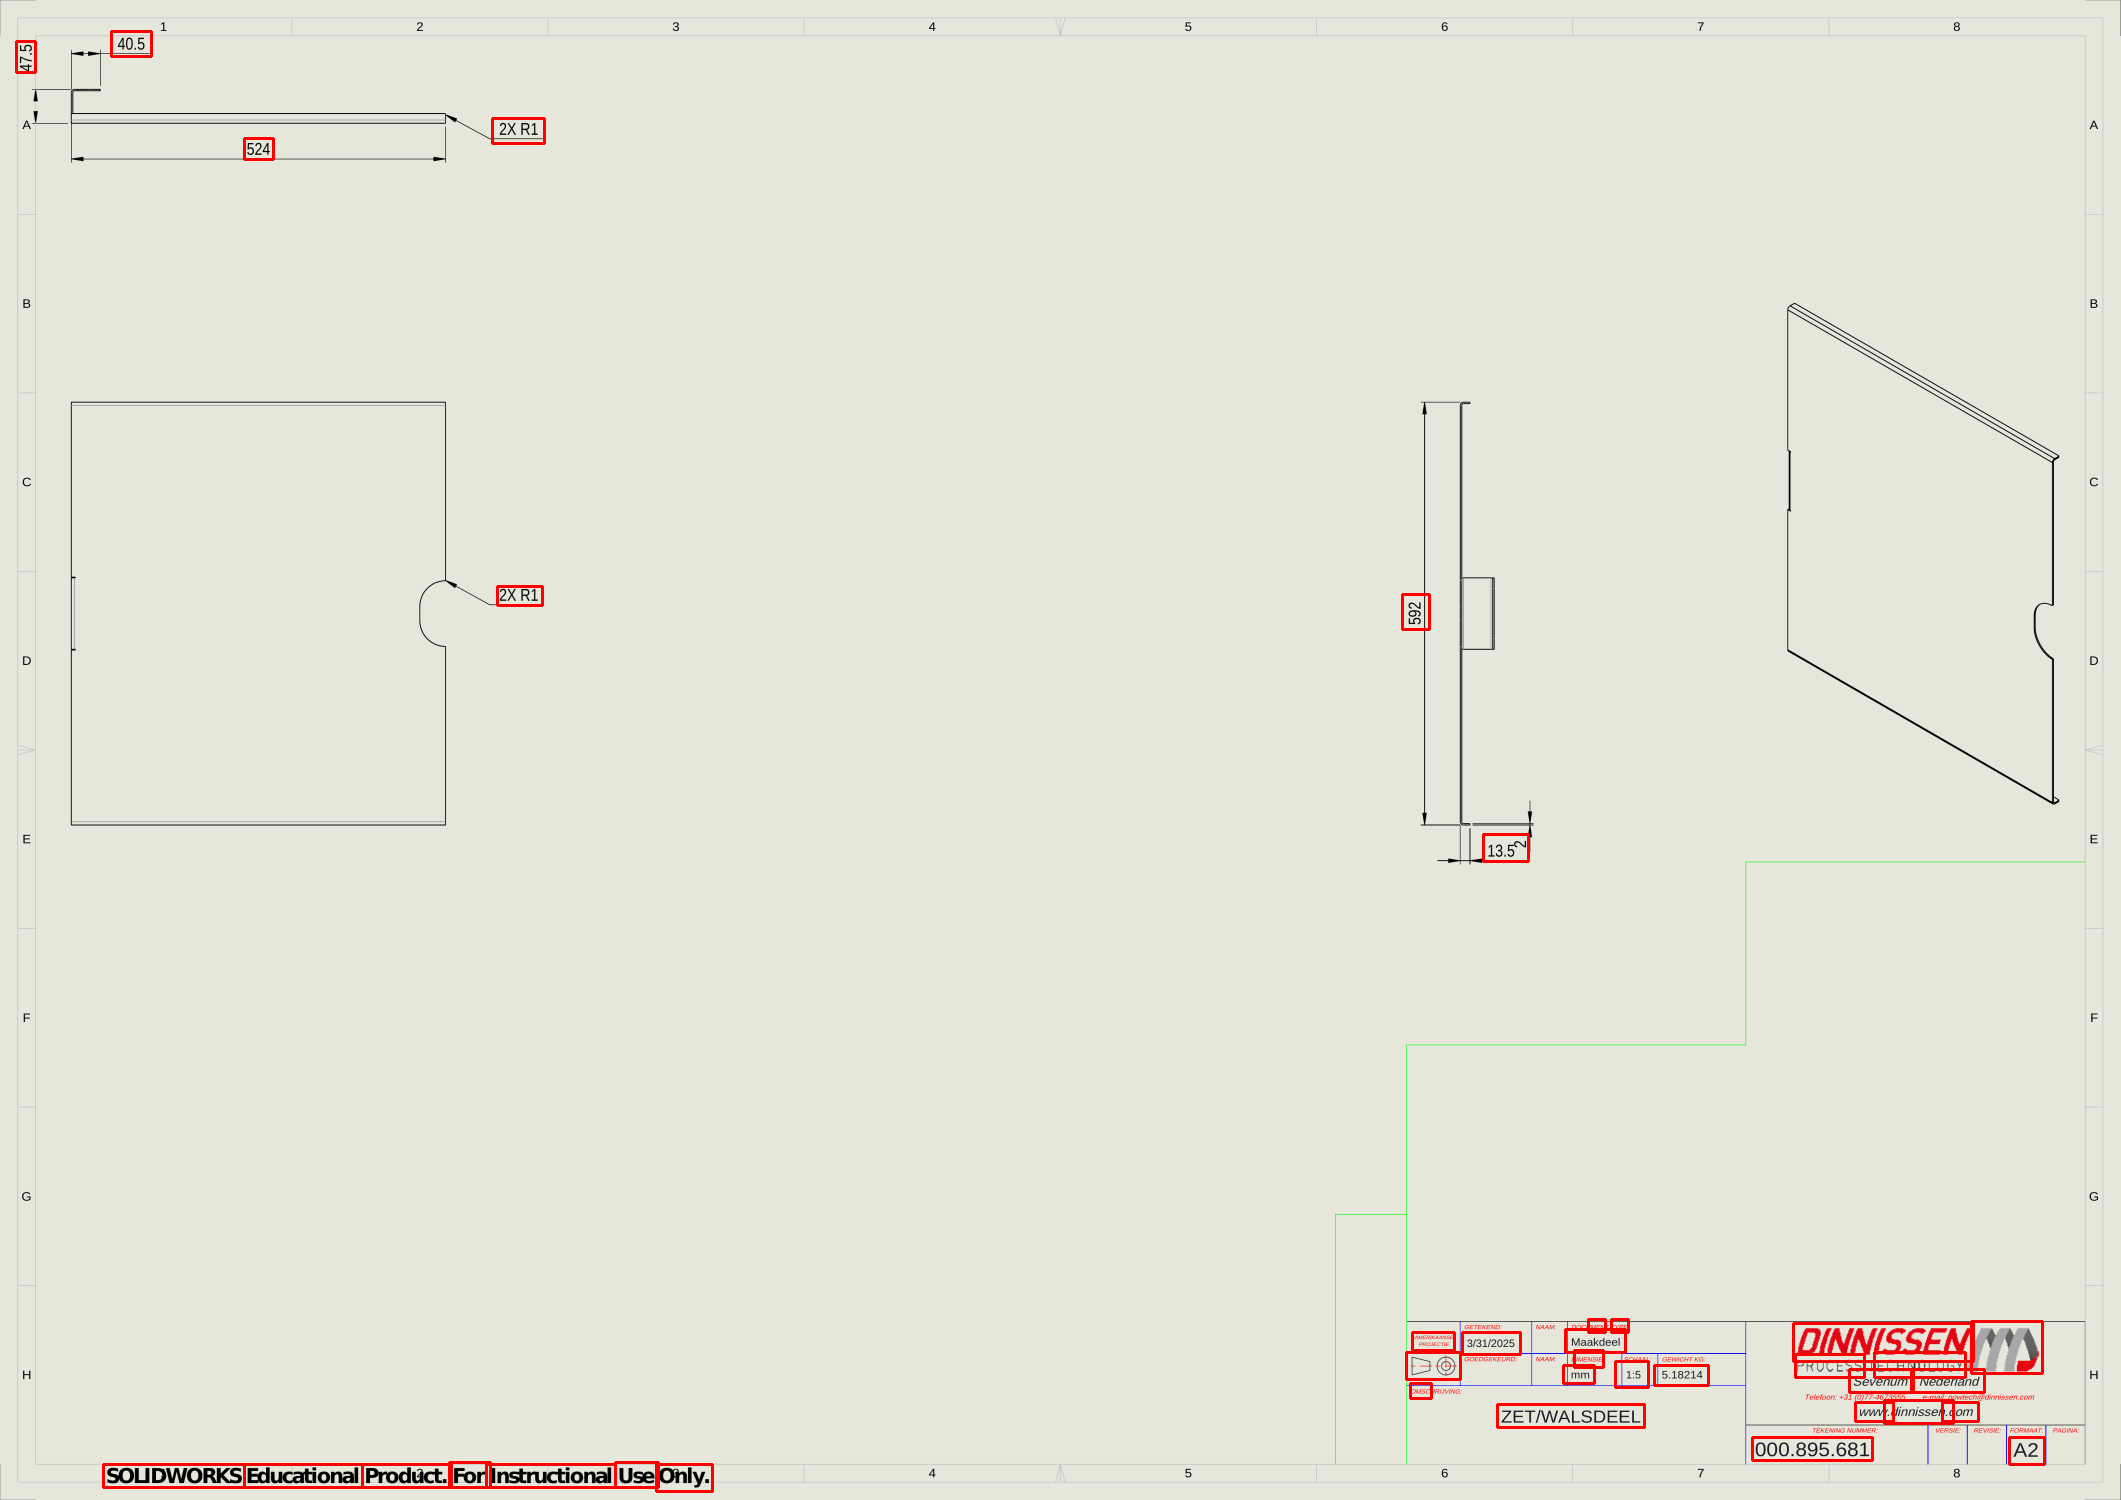

In [1]:
import math
from glob import glob
import os

import cv2
import numpy as np
from PIL import Image
from pdf2image import convert_from_path
from imutils import resize
from sklearn.metrics import euclidean_distances
from tqdm import tqdm
from scoring import *
from border_and_title import *

# f = "../../data/original/Ugly/10.pdf"
# f = "../../data/original/Ugly/2.pdf"
# f = "../../data/original/Ugly/3.pdf"
# f = "../../data/original/Ugly/000.895.652.pdf"
# f = "../../data/original/Good/300-014823.pdf"
# f = "../../data/original/Good/300-014822.pdf"
f = "../../data/original/Ugly/000.895.681.pdf"

font = cv2.FONT_HERSHEY_SIMPLEX
fontScale = 1
color = (255, 0, 0)
thickness = 2

pages = convert_from_path(f, dpi=300)
img = np.array(pages[0])
img = im_resize(img)
img_comp = img.copy()

im_h, im_w, _ = img.shape
sorted_indices, contours, hierarchy_area = detect_objects(img)
title_contours, line_90, data = detect_probable_title_sections(img, return_states=True)
ocr_result = data["ocr_result"]
mask = data["mask"]
inner_border_lines = data["inner_border_lines"]  #  0: Bottom, 1: Top, 2: Right, 3: Left
words = process_text(ocr_result, im_h, im_w)

for idx, row in words.iterrows():
    bx1, by1, bx2, by2 = row[["x1", "y1", "x2", "y2"]].astype(int)
    cv2.rectangle(img_comp, (bx1, by1), (bx2, by2), (255, 0, 0), 2)

Image.fromarray(img_comp)

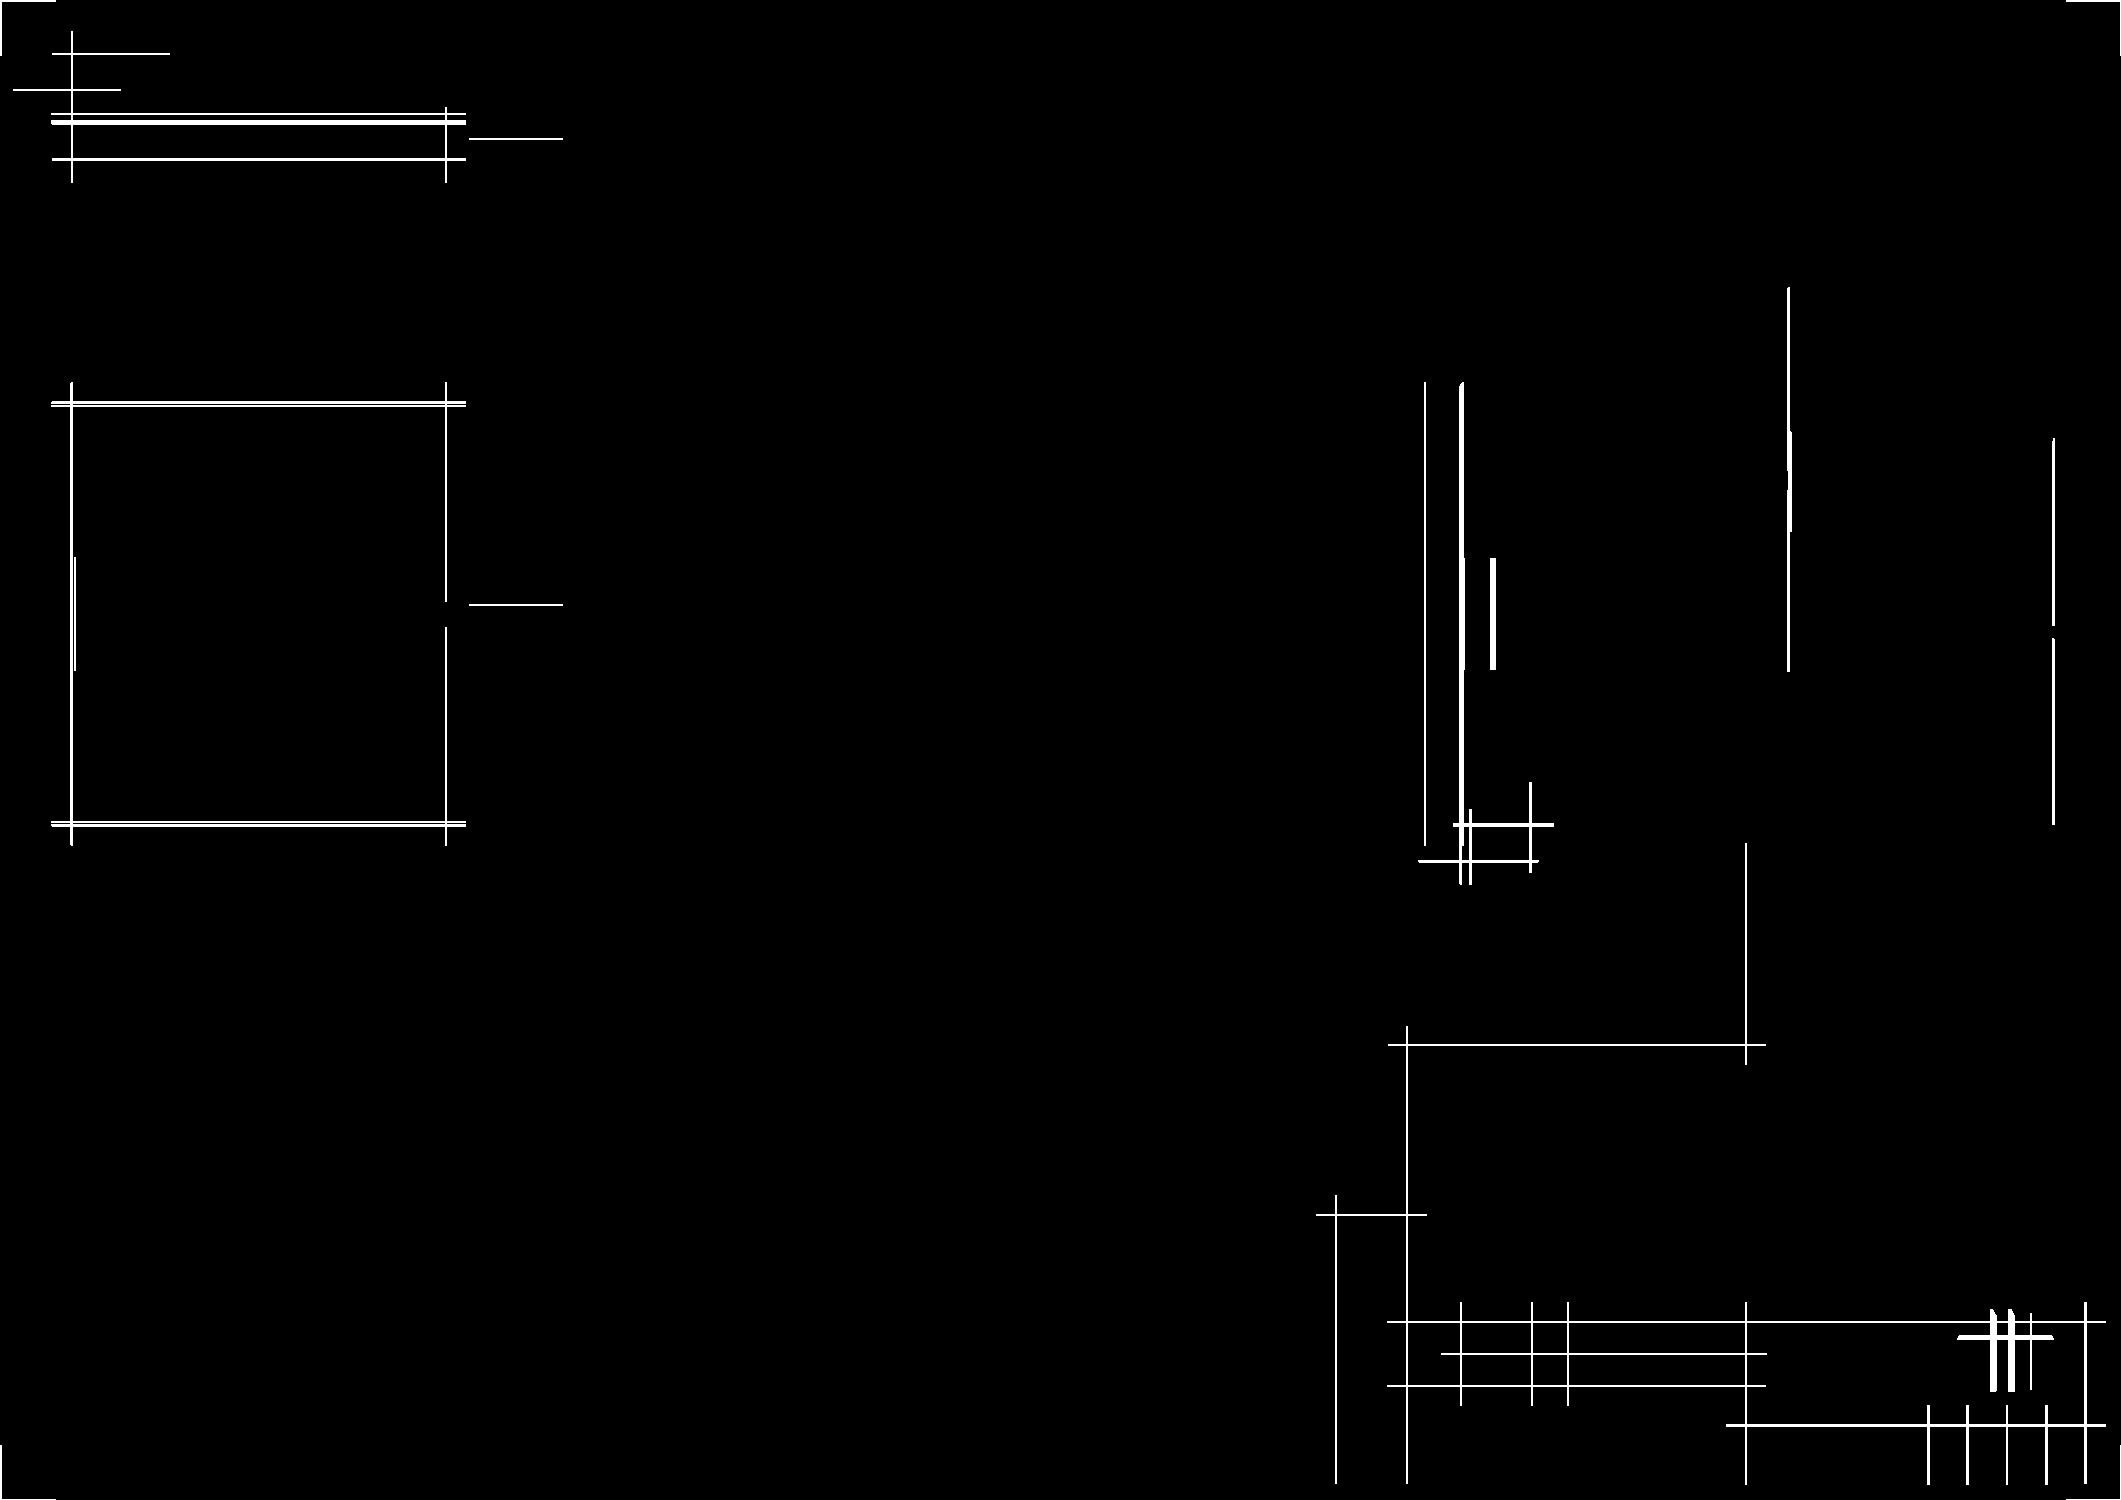

In [2]:
Image.fromarray(mask)

In [3]:
im_h, im_w, _ = img.shape
# 362
# 365
# 366
# 367
# 368
# 369
# 370
# 371
# 372
# 374
# 375
word = words.iloc[20]
bx1, by1, bx2, by2 = word[["x1", "y1", "x2", "y2"]].astype(int)

straight_lines = cv2.HoughLinesP(mask, 1, np.pi / 180, 15, np.array([]), 50, 10)
straight_lines = straight_lines.squeeze(axis=1)

horizontal_lines = []
vertical_lines = []

for (x1, y1, x2, y2) in straight_lines:
    if abs(y1 - y2) <= 5:
        horizontal_lines.append((x1, y1, x2, y2))
    elif abs(x1 - x2) <= 5:
        vertical_lines.append((x1, y1, x2, y2))

horizontal_lines = np.array(horizontal_lines)
vertical_lines = np.array(vertical_lines)
t_dist = 200

horizontal_lines = np.stack([
    np.minimum(horizontal_lines[:, 0], horizontal_lines[:, 2]),
    np.minimum(horizontal_lines[:, 1], horizontal_lines[:, 3]),
    np.maximum(horizontal_lines[:, 0], horizontal_lines[:, 2]),
    np.maximum(horizontal_lines[:, 1], horizontal_lines[:, 3])
], axis=1)

vertical_lines = np.stack([
    np.minimum(vertical_lines[:, 0], vertical_lines[:, 2]),
    np.minimum(vertical_lines[:, 1], vertical_lines[:, 3]),
    np.maximum(vertical_lines[:, 0], vertical_lines[:, 2]),
    np.maximum(vertical_lines[:, 1], vertical_lines[:, 3])
], axis=1)

horizontal_lines

array([[1387, 1321, 2105, 1321],
       [1387, 1322, 2105, 1322],
       [  52,  158,  465,  158],
       [  52,  160,  465,  160],
       [1726, 1424, 2105, 1424],
       [  51,  402,  465,  402],
       [1726, 1426, 2105, 1426],
       [  51,  122,  465,  122],
       [  51,  113,  465,  113],
       [1726, 1425, 2105, 1425],
       [  51,  123,  465,  123],
       [  51,  403,  465,  403],
       [  52,  826,  465,  826],
       [  51,  821,  465,  821],
       [1453,  825, 1553,  825],
       [  51,  114,  465,  114],
       [  51,  121,  465,  121],
       [  52,  159,  465,  159],
       [1387, 1385, 1765, 1385],
       [1388, 1044, 1765, 1044],
       [  51,  822,  465,  822],
       [  51,  120,  465,  120],
       [  52,  124,  465,  124],
       [  51,  406,  465,  406],
       [1441, 1354, 1766, 1354],
       [1387, 1386, 1765, 1386],
       [1441, 1353, 1766, 1353],
       [  51,  405,  465,  405],
       [1388, 1045, 1765, 1045],
       [  51,  824,  465,  824],
       [  

In [4]:
vertical_lines

array([[  72,   31,   72,  182],
       [1459,  386, 1459,  883],
       [  71,   31,   71,  182],
       [ 445,  627,  445,  845],
       [1425,  382, 1425,  845],
       [1406, 1026, 1406, 1483],
       [1460,  384, 1460,  884],
       [1462,  382, 1462,  845],
       [ 446,  627,  446,  845],
       [1407, 1026, 1407, 1483],
       [1461,  383, 1461,  884],
       [1424,  382, 1424,  845],
       [1789,  287, 1789,  671],
       [1745, 1302, 1745, 1484],
       [1788,  287, 1788,  671],
       [2054,  438, 2054,  625],
       [2053,  438, 2053,  625],
       [1787,  288, 1787,  470],
       [1746,  843, 1746, 1064],
       [1336, 1195, 1336, 1483],
       [2052,  441, 2052,  625],
       [1463,  382, 1463,  845],
       [2084, 1302, 2084, 1483],
       [1335, 1195, 1335, 1483],
       [  70,  383,   70,  844],
       [2052,  665, 2054,  824],
       [2086, 1302, 2086, 1483],
       [   0,    0,    0,   55],
       [2085, 1302, 2085, 1483],
       [2012, 1315, 2014, 1391],
       [20

In [5]:
x = int((bx1 + bx2) / 2)
y = int((by1 + by2) / 2)

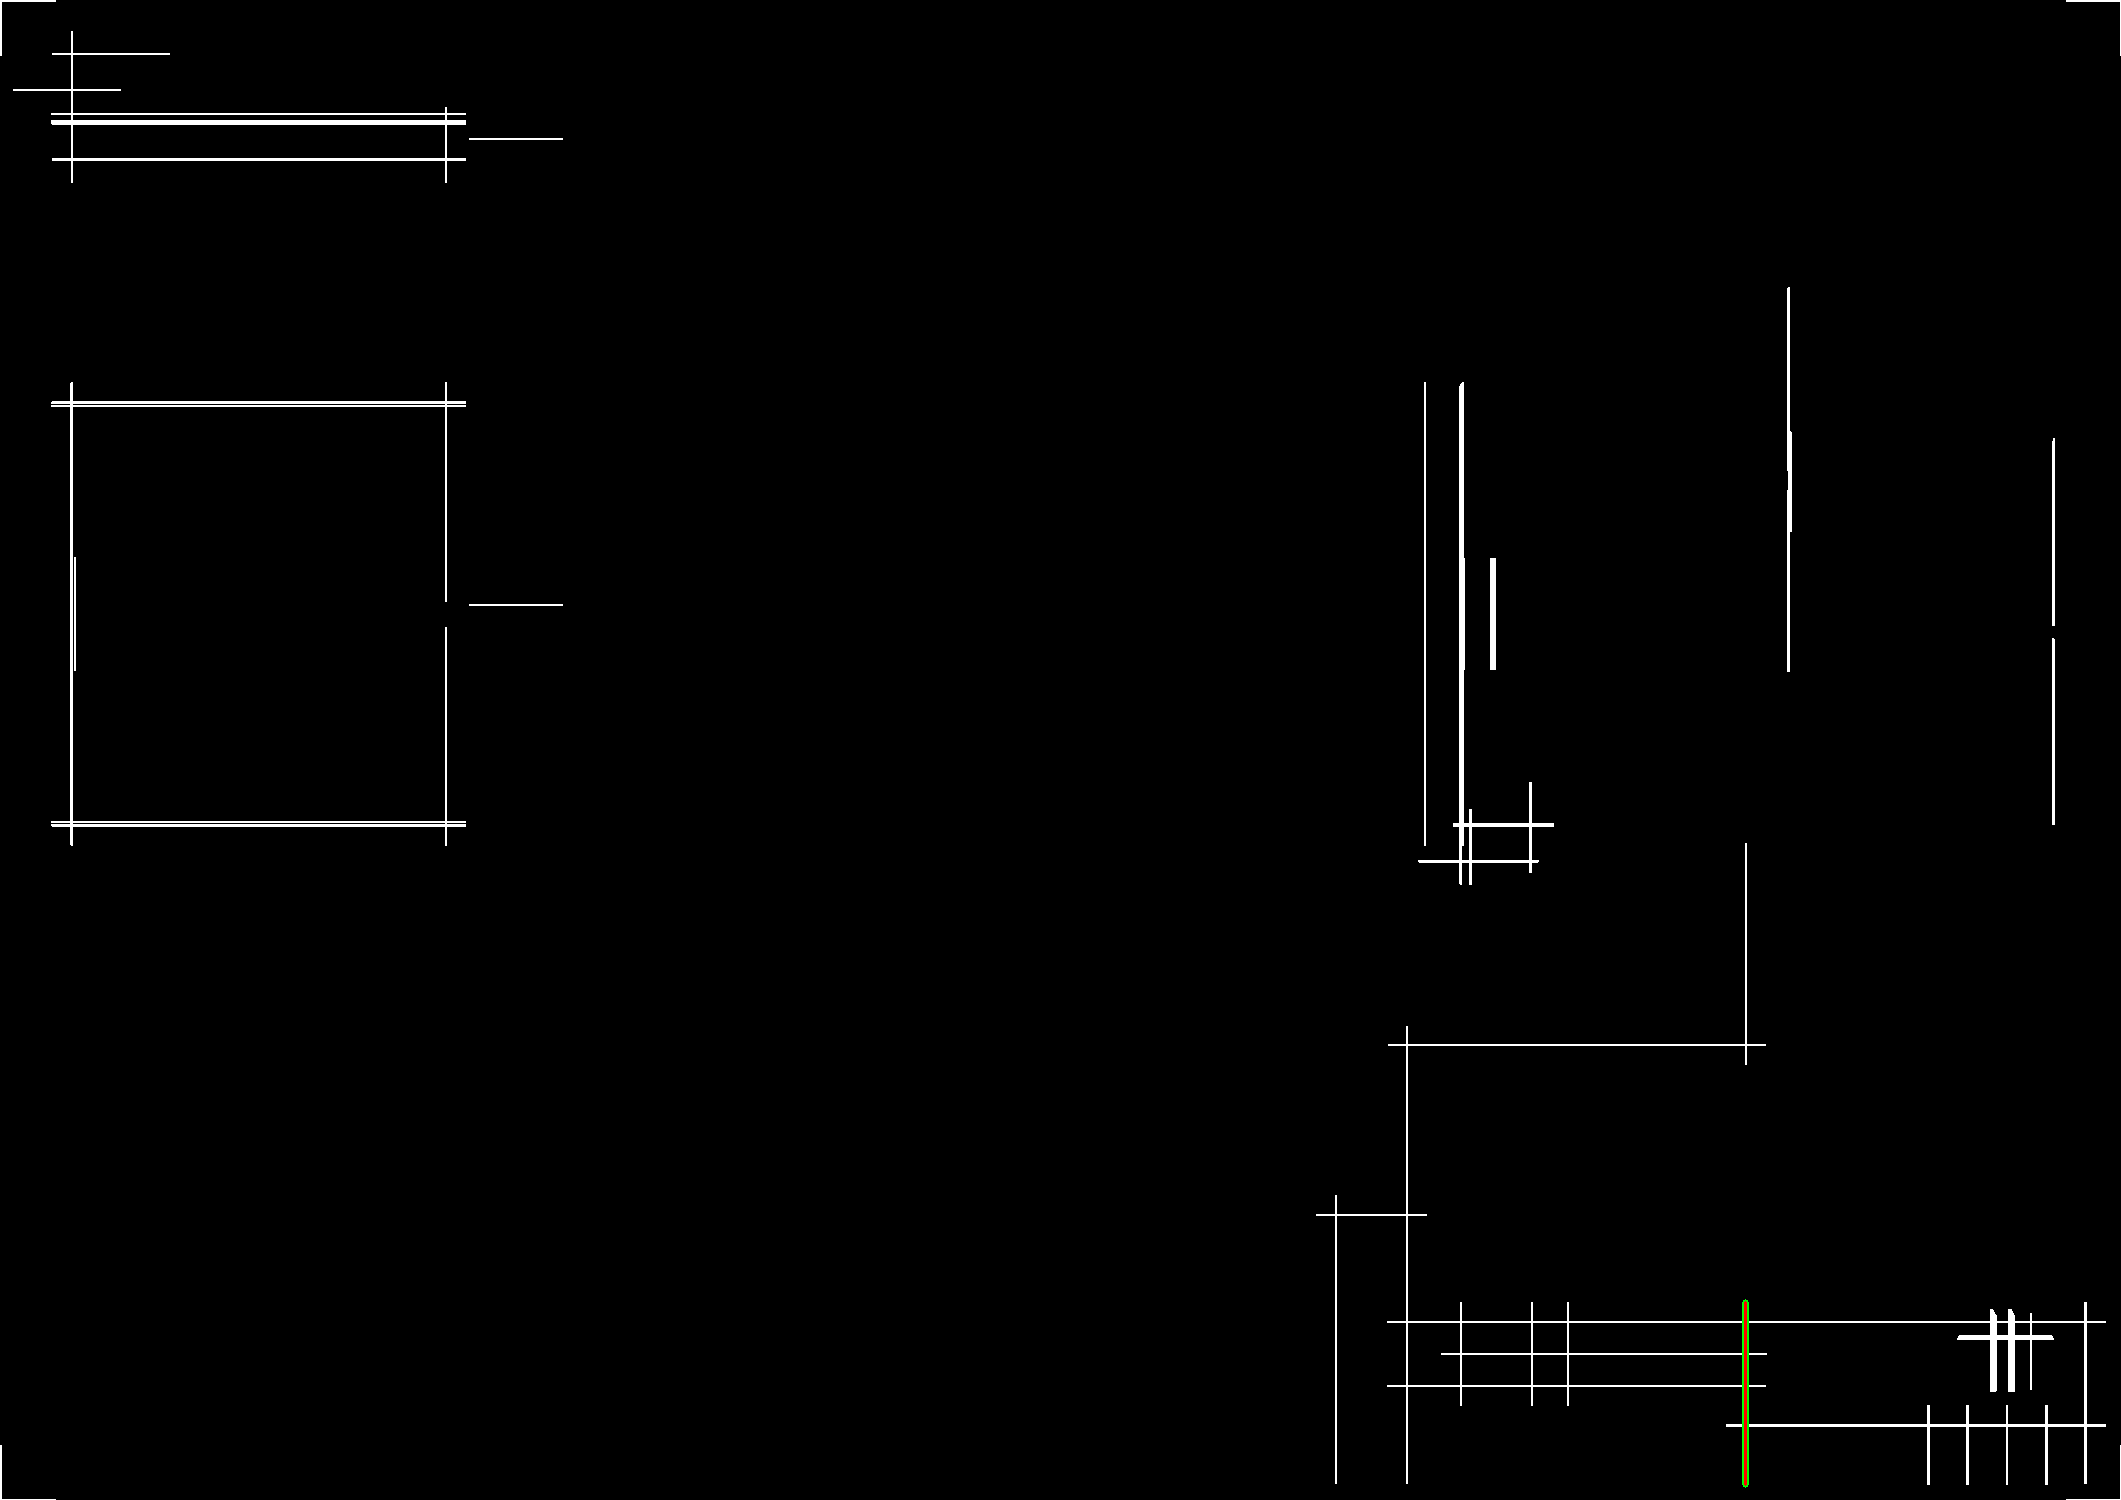

In [6]:
img_comp = mask.copy()
img_comp = cv2.cvtColor(img_comp, cv2.COLOR_GRAY2BGR)

left = vertical_lines[(vertical_lines[:, 0] < bx1) & (vertical_lines[:, 0] > (bx1 - t_dist)) & (vertical_lines[:, 1] < y) & (vertical_lines[:, 3] > y)]
# left = vertical_lines[(vertical_lines[:, 0] < bx1) & (vertical_lines[:, 0] > (bx1 - t_dist)) & (vertical_lines[:, 1] > by1) & (vertical_lines[:, 3] < by2)]

for (x1, y1, x2, y2) in left:
    cv2.line(img_comp, (x1, y1), (x2, y2), (0, 255, 0), 5)

left = left[left[:, 0].argmax()]
x1, y1, x2, y2 = left
cv2.line(img_comp, (x1, y1), (x2, y2), (255, 0, 0), 2)

Image.fromarray(img_comp)

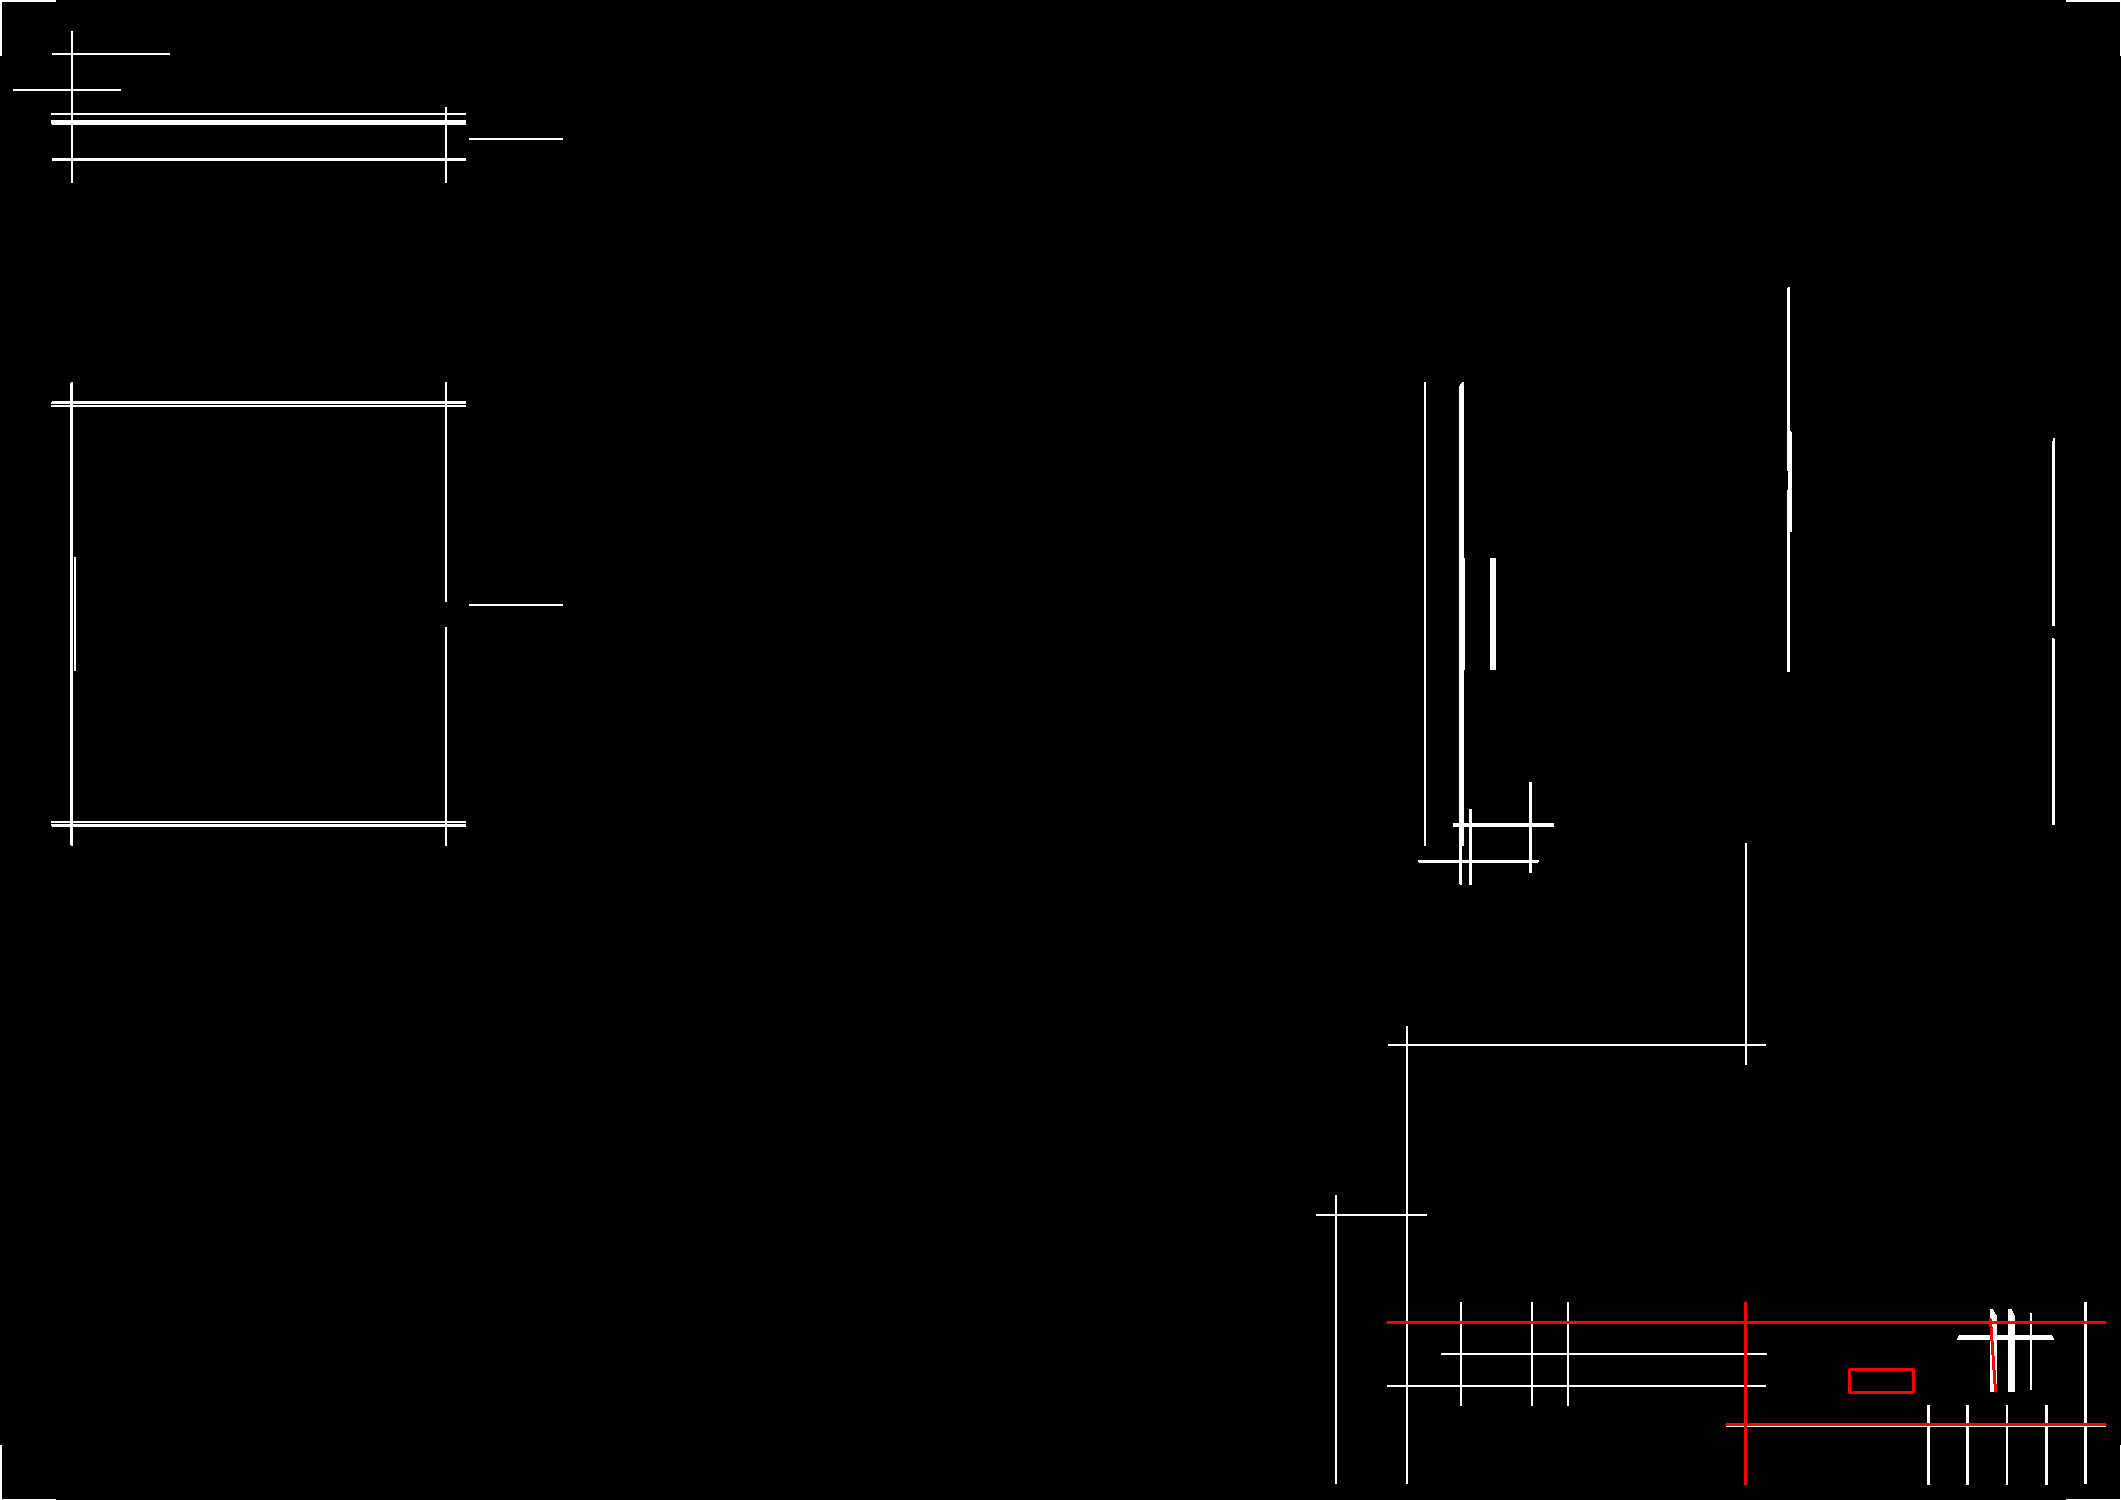

In [7]:
img_comp = mask.copy()
img_comp = cv2.cvtColor(img_comp, cv2.COLOR_GRAY2BGR)

top = horizontal_lines[(horizontal_lines[:, 1] < y) & (horizontal_lines[:, 1] > (y - t_dist)) & (horizontal_lines[:, 0] < x) & (horizontal_lines[:, 2] > x)]
top = top[top[:, 1].argmax()]

bottom = horizontal_lines[(horizontal_lines[:, 1] > y) & (horizontal_lines[:, 1] < (y + t_dist)) & (horizontal_lines[:, 0] < x) & (horizontal_lines[:, 2] > x)]
bottom = bottom[bottom[:, 0].argmax()]

right = vertical_lines[(vertical_lines[:, 0] > x) & (vertical_lines[:, 0] < (x + t_dist)) & (vertical_lines[:, 1] < y) & (vertical_lines[:, 3] > y)]
right = right[right[:, 0].argmin()]

left = vertical_lines[(vertical_lines[:, 0] < bx1) & (vertical_lines[:, 0] > (bx1 - t_dist)) & (vertical_lines[:, 1] < y) & (vertical_lines[:, 3] > y)]
left = left[left[:, 0].argmax()]

word_lines = np.array([left, top, right, bottom])

bx1, by1, bx2, by2 = word[["x1", "y1", "x2", "y2"]].astype(int)
cv2.rectangle(img_comp, (bx1, by1), (bx2, by2), (255, 0, 0), 2)

for (x1, y1, x2, y2) in word_lines:
    cv2.line(img_comp, (x1, y1), (x2, y2), (255, 0, 0), 2)

Image.fromarray(img_comp)